# Non-negative CP Tensor Factorization as a Circuit

TODO

TODO

In [1]:
from cirkit.templates import tensor_factorizations, utils

num_images, image_height, image_width = 4096, 28, 28
symbolic_circuit = tensor_factorizations.cp(
    # The shape of the tensor to which encode the CP factorization of
    (num_images, image_height, image_width),
    rank=128, # The rank of the CP factorization
    # Parameterize the factor matrices using a softmax activation function
    factor_param=utils.Parameterization(
        initialization="normal",
        activation="sigmoid",
        #activation_kwargs={"axis": 0}
    ),
    weight_param=utils.Parameterization(
        initialization="normal",
        activation="softmax",
        activation_kwargs={"axis": -1}
    )
)

TODO

In [2]:
from cirkit.pipeline import PipelineContext

ctx = PipelineContext(backend="torch", semiring="sum-product", fold=True)
circuit = ctx.compile(symbolic_circuit)

TODO

In [3]:
import random
import numpy as np
import torch

# Set some seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the torch device to use
device = torch.device('cuda')

In [4]:
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets

# Load the MNIST data set
transform = transforms.ToTensor()
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)

# Sub-sample a few images only
idx_samples = np.arange(len(data_train))
np.random.shuffle(idx_samples)
idx_samples = idx_samples[:num_images]

# Construct the tensor to approximate
tensor = torch.cat([data_train[i][0] for i in idx_samples], dim=0)
print(f"Shape of the tensor to approximate: {tensor.shape}")

# Construct a data loader that randomly samples indices of the tensor to approximate
indices = np.stack(np.mgrid[0:tensor.shape[0], 0:tensor.shape[1], 0:tensor.shape[2]], axis=-1).reshape(-1, 3)
train_dataloader = DataLoader(TensorDataset(torch.from_numpy(indices)), shuffle=True, batch_size=65536, drop_last=True)
print(f"Number of indices: {len(indices)}")

Shape of the tensor to approximate: torch.Size([4096, 28, 28])
Number of indices: 3211264


TODO

In [5]:
# Initialize a torch optimizer of your choice,
optimizer = optim.Adam(circuit.parameters(), lr=0.1)

TODO

In [6]:
num_epochs = 25
running_loss = 0.0
running_samples = 0

# Move the target tensor to the chosen device
tensor = tensor.to(device)

# Move the circuit to chosen device
circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    for i, (batch,) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        batch = batch.to(device).unsqueeze(dim=1)

        # Compute the value of the tensor at the indices in the batch
        tvalues = circuit(batch)  # shape (batch_dim, 1, 1)

        #print(tvalues.min(), tvalues.mean(), tvalues.max())
        
        # We take the MSE as loss
        target_tvalues = tensor[batch[:, 0, 0], batch[:, 0, 1], batch[:, 0, 2]]
        loss = torch.mean(torch.square(target_tvalues - tvalues[:, 0, 0]))
        loss.backward()

        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * len(batch)
        running_samples += len(batch)
    average_mse = running_loss / running_samples
    print(f"Epoch {epoch_idx + 1}: Average MSE: {average_mse:.3f}")
    running_loss = 0.0
    running_samples = 0

Epoch 1: Average MSE: 0.071
Epoch 2: Average MSE: 0.063
Epoch 3: Average MSE: 0.061
Epoch 4: Average MSE: 0.060
Epoch 5: Average MSE: 0.059
Epoch 6: Average MSE: 0.059
Epoch 7: Average MSE: 0.058
Epoch 8: Average MSE: 0.058
Epoch 9: Average MSE: 0.058


KeyboardInterrupt: 

TODO

Shape of the factor associated to the 0-th tensor index: torch.Size([4096, 128])
Shape of the factor associated to the 1-th tensor index: torch.Size([28, 128])
Shape of the factor associated to the 2-th tensor index: torch.Size([28, 128])


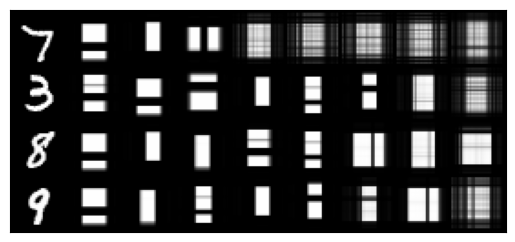

In [9]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Disable autograd from now on
circuit.eval()

# First, retrieve the non-negative factor matrices from the circuit embedding layers
factors: dict[int, torch.Tensor] = {
    layer.scope_idx[fold_idx].item(): layer.weight()[fold_idx, :, 0].T
    for layer in circuit.inputs
    for fold_idx in range(layer.num_folds)
}
for idx, factor in factors.items():
    print(f"Shape of the factor associated to the {idx}-th tensor index: {factor.shape}")

# Plot the images and their computed basis
num_images = 4
num_basis = 8
all_images = []
for i in range(num_images):
    # Retrieve the basis images having the highest importance
    importances = factors[0][i]
    best_basis_idx = torch.argsort(importances, descending=True)[:num_basis]
    height_basis = factors[1]
    width_basis = factors[2]
    basis = [torch.outer(height_basis[:, r], width_basis[:, r]) for r in best_basis_idx]

    # Moreover, reconstruct the image using the basis
    recon_image = torch.sum(torch.stack([
        torch.outer(height_basis[:, r], width_basis[:, r])
        for r in range(len(importances))
    ], dim=-1) * importances, dim=-1)

    # Retrieve the original image
    target_image = tensor[i]

    # Append the original image, the basis and the reconstructed image to the list of all images we will plot
    all_images.append(target_image.unsqueeze(dim=0))
    all_images.extend(b.unsqueeze(dim=0) for b in basis)
    all_images.append(recon_image.unsqueeze(dim=0))

grid_images = make_grid(all_images, nrow=num_basis + 2)
plt.imshow(grid_images.permute(1, 2, 0).cpu().numpy())
plt.xticks([], [])
plt.yticks([], [])
plt.show()